This file will show how left speed in cozmo can be classified between anger and sorow

# Lessons from this:

### From Fig 1.
#### The average speed in anger is higher than sorrow. Sorrow tends to be idle far more often than anger 
### From Fig 2.
#### The area under the curve on speed, is very low on sorrow, meaning that it is very probable that the whole speed in sorrow is low or not at all (idle)

# 1 Input Packages

In [158]:
import sys
!{sys.executable} -m pip install tslearn tslearn  tqdm -U

Requirement already up-to-date: tslearn in /anaconda3/lib/python3.7/site-packages (0.3.0)
Requirement already up-to-date: tqdm in /anaconda3/lib/python3.7/site-packages (4.43.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy import stats

import seaborn as sns; sns.set(color_codes=True)

from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, cdist_dtw

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 2 Variables and structures

In [8]:
valence_values=['interest','alarm', 'confusion', 'understanding', 'frustration', 'relief',
       'sorrow', 'joy', 'anger', 'gratitude', 'fear', 'hope', 'boredom',
       'surprise', 'disgust', 'desire']
cozmo_feature='left_wheel_speed'
seq_len=60

# 3 Load Data

In [9]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )

# 4 Generate subset of data, one per affect

In [10]:
def getSubsetViaAffect(affect='', dataframe='', mutuallyExclusive=True):
    vectorMaxLenght=60
    retVal=[]
    
    #for a in range(0, len(dataframe), 60):
    for a in tqdm(range(0, len(dataframe), 60)):
        tmp=(dataframe[a:a+60])
        if ((mutuallyExclusive == True) and ((np.sum(list(tmp.Y)[0])) > 1)):
            continue
        # remove Y column
        tmp2=tmp.drop(['Y'],axis=1)
        tmp3=tmp2.loc[(tmp2!=0).any(1)]
        feat=(list(tmp.Y))[0]
        features=[]
        for i in range(len(feat)):
            if 1 in feat:
                features.append(valence_values[feat.index(1)])
                feat[feat.index(1)]=0
            else:
                break
            
        for f in features:
            if f == affect:
                retVal.append(tmp3)
        
    return retVal

In [11]:
anger=getSubsetViaAffect(affect='anger', dataframe=d, mutuallyExclusive=False)

In [12]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
sorrow=getSubsetViaAffect(affect='sorrow', dataframe=d, mutuallyExclusive=False)

# 5 Distributions between the two affects
### Objective: See patterns of general behavior in terms of speed


In [5]:
cozmo_feature

'left_wheel_speed'

In [13]:
anger_list=[np.sum(list(abs(a[cozmo_feature])))/60 for a in anger]
sorrow_list=[np.sum(list(abs(a[cozmo_feature])))/60 for a in sorrow]

## Fig 1.- PDF of average speed on each animation (full 60 samples per animation)

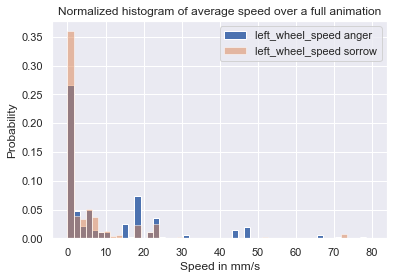

In [14]:
_, bins, _ = plt.hist(anger_list, bins=50, range=[0,80], density=True, 
                      label=['{} anger'.format(cozmo_feature)])
_ = plt.hist(sorrow_list, bins=bins, alpha=0.5, density=True, 
             label=['{} sorrow'.format(cozmo_feature)])
plt.legend(loc='best')
plt.xlabel('Speed in mm/s')
plt.ylabel('Probability')
plt.title('Normalized histogram of average speed over a full animation')
plt.show()

In [17]:
all_data=[list(a.left_wheel_speed) for a in anger]

In [21]:
len(all_data)*60

13860

# 6 Integral per animation and make histogram of the areas under the curve.
## This is using the discrete aproximation by trapezoidal rule.
### Objective: Contrary to the average speed, I want to learn the total area of speed in an animation. This will give me a clue of how much speed in a full animation each affect tends to have.

In [15]:
anger_integral=[]
for a in anger:
    left=list(a[cozmo_feature])
    # absolute values onlly
    res = list(map(abs, left)) 
    anger_integral.append(np.trapz(res))
sorrow_integral=[]
for a in sorrow:
    left=list(a[cozmo_feature])
    # absolute values onlly
    res = list(map(abs, left)) 
    sorrow_integral.append(np.trapz(res))

# Fig 2.- Integral of speed on each animation

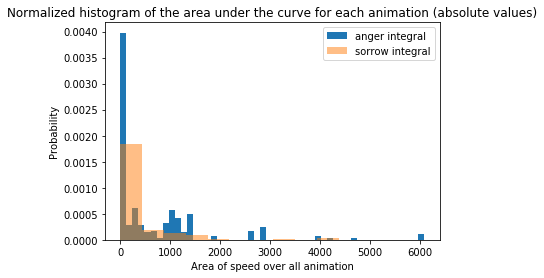

In [43]:
_, bins, _ = plt.hist(anger_integral, bins=50,  density=True, label=['anger integral'])
_ = plt.hist(sorrow_integral,  alpha=0.5, density=True, label=['sorrow integral'])
plt.legend(loc='upper right')
plt.xlabel('Area of speed over all animation')
plt.ylabel('Probability')
plt.title('Normalized histogram of the area under the curve for each animation (absolute values)')
plt.show()

# 7 Clustering time series
### Objective: Detect patterns on each affect in the time series

In [16]:
# Data is the list of datagrams
def cluster_patterns(data, clusters, title):
    all_data=[list(a.left_wheel_speed) for a in data]
    X_train = np.asarray(all_data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    # DBA-k-means
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                        n_init=6,
                        max_iter=5000,
                        dtw_inertia=True,
                        metric="dtw",
                        verbose=False,
                        max_iter_barycenter=10,
                        random_state=0,
                        n_jobs=-1)
    y_pred = dba_km.fit_predict(X_train)
    plt.figure(figsize=(15,4))
    for yi in range(clusters):
        plt.subplot(1, clusters, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        #plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(title)



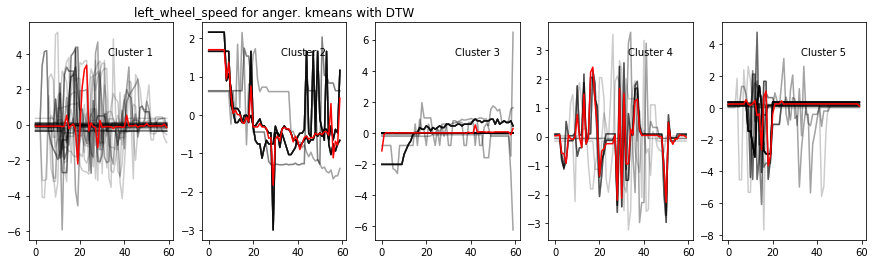

In [93]:
cluster_patterns(anger, 5, "{} for anger. kmeans with DTW".format(cozmo_feature))

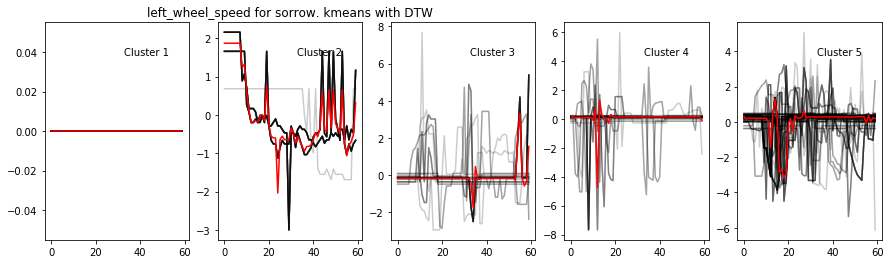

In [94]:
cluster_patterns(sorrow, 5, "{} for sorrow. kmeans with DTW".format(cozmo_feature))

# Classification time series

https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

In [116]:
def splitdf(df1='',df2=''):
    y1=[1]*len(df1)
    y2=[0]*len(df2)
    X=df1+df2
    Y=y1+y2
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        test_size=0.33, 
                                                        random_state=0)
    print(len(X_train),len(y_train))
    print(len(X_test),len(y_test))
    return X_train, X_test, y_train, y_test

    
X_train_t, X_test, y_train_t, y_test=splitdf(df1=anger, df2=sorrow)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_t, y_train_t, 
                                                        test_size=0.33, 
                                                        random_state=0)

377 377
186 186


In [117]:
len(X_train), len(X_validation), len(X_test)

(252, 125, 186)

In [118]:
len(y_train), len(y_validation), len(y_test)

(252, 125, 186)

In [119]:
def convert_to_ts(data, feature):
    concat_list=[[list(d[cozmo_feature])] for d in data]
    return np.array(concat_list)
X_train=convert_to_ts(X_train,cozmo_feature)
X_validation=convert_to_ts(X_validation,cozmo_feature)
X_test=convert_to_ts(X_test,cozmo_feature)

In [120]:
X_train.shape, X_validation.shape, X_test.shape

((252, 1, 60), (125, 1, 60), (186, 1, 60))

In [121]:
train = X_train
validation = X_validation
test = X_test
train_target=np.array(y_train)
validation_target=np.array(y_validation)
test_target=np.array(y_test)

In [122]:
#row,cols=train.shape
#train = train.reshape(1,row, cols)
#row,cols=train_target.shape
#train_target = train_target.reshape(1,row, cols)

#row,cols=validation.shape
#validation = validation.reshape(1,row, cols)
#row,cols=validation_target.shape
#validation_target = validation_target.reshape(1,row, cols)

#row,cols=test.shape
#test = test.reshape(1,row, cols)
#row,cols=test_target.shape
#test_target = test_target.reshape(1,row, cols)



In [123]:
model = Sequential()
model.add(LSTM(256, input_shape=(1,seq_len)))
model.add(Dense(1, activation='sigmoid'))

In [1]:
type(train)

NameError: name 'train' is not defined

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               324608    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 324,865
Trainable params: 324,865
Non-trainable params: 0
_________________________________________________________________


In [125]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))
#model.fit(train, train_target, epochs=200, batch_size=128)


Train on 252 samples, validate on 125 samples
Epoch 1/200
252/252 [==============================] - 1s 4ms/step - loss: 0.7077 - acc: 0.5714 - val_loss: 0.6597 - val_acc: 0.6160
Epoch 2/200
252/252 [==============================] - 0s 79us/step - loss: 0.6181 - acc: 0.6865 - val_loss: 0.6377 - val_acc: 0.6480
Epoch 3/200
252/252 [==============================] - 0s 79us/step - loss: 0.5763 - acc: 0.7262 - val_loss: 0.6241 - val_acc: 0.6640
Epoch 4/200
252/252 [==============================] - 0s 84us/step - loss: 0.5518 - acc: 0.7381 - val_loss: 0.6145 - val_acc: 0.6560
Epoch 5/200
252/252 [==============================] - 0s 87us/step - loss: 0.5330 - acc: 0.7421 - val_loss: 0.6074 - val_acc: 0.6480
Epoch 6/200
252/252 [==============================] - 0s 92us/step - loss: 0.5176 - acc: 0.7579 - val_loss: 0.6010 - val_acc: 0.6480
Epoch 7/200
252/252 [==============================] - 0s 92us/step - loss: 0.5071 - acc: 0.7579 - val_loss: 0.5942 - val_acc: 0.6320
Epoch 8/200
252/2

In [126]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.6559139784946236

In [54]:
test_target[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [49]:
#xx=list(sorrow[16].left_wheel_speed)
xx=list(sorrow[86].left_wheel_speed)
#yy=sorrow[6].columns
#model.predict_classes(
x2=np.array(xx)
print(x2)
x2=x2.reshape(1,1,60)
x2.shape
model.predict_classes(x2)

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  -90. -100. -102.   33.   33.   33.   33.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]


array([[0]], dtype=int32)

#  Show distance among affects

Step 1. Let's take 4 affects, 2 close together on high arousal, and two close togheter on low arousal

What I will test here?: The two high arousal should be close together in distance, but enough distant to be two different classes, and the same thing with the low arousal.

Also, the distance between the low arousals and high arousal should be longer than among the same arousal


If this doesn't happen, it's ok, we have basic moves based on the paper "It’s not the way you look, it’s how you move: Validating a general scheme for robot affective behavior.
", and this could be a movemenmt that is shared among those affects

Source: https://www.researchgate.net/publication/259234751_The_Role_of_Time_in_Music_Emotion_Recognition/figures?lo=1

![alt text](loop.png "Cirumplex model of Affect")

### Step 1.- Get the data

Hi arousal, opposite on valence: anger,surprise

In [236]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
anger=getSubsetViaAffect(affect='anger', dataframe=d, mutuallyExclusive=False)
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
joy=getSubsetViaAffect(affect='joy', dataframe=d, mutuallyExclusive=False)
print(len(anger), len(joy))



231 352


Now low Arousal and oposite on valence: sorrow, Boredom

In [237]:
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
sorrow=getSubsetViaAffect(affect='sorrow', dataframe=d, mutuallyExclusive=False)
d = pickle.load( open( "data/all_affect_dataframe.p", "rb" ) )
boredom=getSubsetViaAffect(affect='boredom', dataframe=d, mutuallyExclusive=False)
print(len(understand), len(boredom))


357 162


#### Now convert the 4 groups to time series

In [238]:
def convertTimeSeries(data):
    all_data=[list(a.left_wheel_speed) for a in data]
    return to_time_series_dataset(all_data)
    #return all_data

In [239]:
anger_ts      = convertTimeSeries(anger)
joy_ts   = convertTimeSeries(joy)
sorrow_ts = convertTimeSeries(sorrow)
boredom_ts    = convertTimeSeries(boredom)

### Rationale:
###### From A and B, which one has more similarity to C
###### I will do dwt(A,C) and dtw(B,C). The one that has
###### less distance, has more similarity

###### Test 1: Distance between Anger Surprise, let's call it
###### D_alarm_surprise
###### This distance should be short, they have the same arousal but opposite valence

In [240]:
def similarity(ts1, ts2, title1, title2):
    retVal = cdist_dtw(ts1, 
                       ts2,
                      n_jobs=-1,
                      verbose=0)
    #print("The distance between {} and {} is {}".format(title1,
                                                       #title2,
                                                       #retVal))
    return retVal

In [241]:
D_anger_joy = similarity(anger_ts, joy_ts, 'Anger', 'Joy')
D_anger_sorrow = similarity(anger_ts, sorrow_ts, 'Anger', 'Sorrow')
D_anger_boredom = similarity(anger_ts, boredom_ts, 'Anger', 'Boredom')
#D_alarm_surprise = similarity(alarm_ts, surprise_ts, 'Alarm', 'Surprise')


In [242]:
def analysisCrossSsimilarityMatrix(data, title):
    data_1d=list(data.flatten())
    print(stats.describe(data_1d))
    _, bins, _ = plt.hist(data, density=True,
                          histtype='bar',
                          bins='auto',
                      label=['Distnces between{}'.format(title)])
    plt.legend(loc='best')
    plt.xlabel('Distances')
    plt.ylabel('Occurrences')
    plt.title('Histogram of dynamic time warp\'s cross similarity matrix')
    plt.show()


In [243]:
import pandas as pd
def analysisCrossSsimilarityMatrixkde(data, title):
    data_1d=data.flatten()
    d=pd.Series(data_1d)
    ax = d.plot.kde()



81312 76692 37422


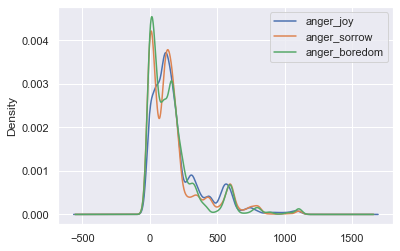

In [247]:
def analysisCrossSsimilarityMatrixkde2(data1, data2, data3, title):
    data_1d=(data1.flatten()).tolist()
    data_2d=(data2.flatten()).tolist()
    data_3d=(data3.flatten()).tolist()
    print(len(data_1d), len(data_2d), len(data_3d))
    data_1d=data_1d[0:37422]
    data_2d=data_2d[0:37422]
    data_3d=data_3d[0:37422]
    df = pd.DataFrame({
    'anger_joy': data_1d,
    'anger_sorrow': data_2d,
    'anger_boredom': data_3d
    })
    ax = df.plot.kde()
analysisCrossSsimilarityMatrixkde2(D_anger_joy, D_anger_sorrow,D_anger_boredom, "Anger Joy distance")

In [250]:
df = pd.DataFrame(np.random.randn(10, 4),
                  columns=['Col1', 'Col2', 'Col3', 'Col4'])

In [253]:
a=np.random.randn(10, 4)

In [264]:
data_1d=(D_anger_joy.flatten()).tolist()
data_2d=(D_anger_sorrow.flatten()).tolist()
data_3d=(D_anger_boredom.flatten()).tolist()
data_1d=data_1d[0:37422]
data_2d=data_2d[0:37422]
data_3d=data_3d[0:37422]
join_data=np.array([data_1d, data_2d, data_3d])
join_data=join_data.reshape(37422,3)

In [266]:
df = pd.DataFrame(join_data,
                  columns=['anger_joy', 'anger_sorrow', 'anger_boredom'])




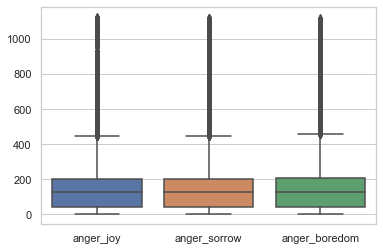

In [269]:
ax = sns.boxplot(data=df)

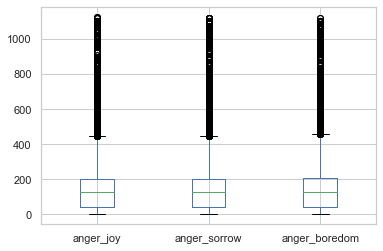

In [270]:
boxplot = df.boxplot(column=['anger_joy', 'anger_sorrow', 'anger_boredom'])


